In [45]:
from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import astropy.units as u
import astropy.io.fits
import astropy.time
import astropy.table
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.visualization import ImageNormalize, AsinhStretch
import sunpy.map
from sunpy.coordinates import propagate_with_solar_surface
import ndcube
from sunkit_image.time_lag import time_lag

from dask_gateway import Gateway
from dask.distributed import PipInstall
import dask.array

%matplotlib inline

Define some needed functions for querying data and making cutouts

In [63]:
def search_registry(start_date, end_date, wavelength, bucket=None):
    import scregistry
    if bucket is None:
        bucket = "s3://gov-nasa-hdrl-data1/"
    file_registry = scregistry.FileRegistry(bucket)
    results =  file_registry.request_file_registry(
        f'aia_{int(wavelength.to_value("angstrom")):04d}',
        start_date=f'{start_date.isot}Z',
        stop_date=f'{end_date.isot}Z',
        overwrite=False
    )
    results = astropy.table.Table.from_pandas(results)
    return results


def map_from_s3_file(filename):
    with astropy.io.fits.open(filename, use_fsspec=True, fsspec_kwargs={'anon': True}) as hdul:
        header = hdul[1].header
        data = hdul[1].data
    return sunpy.map.Map(data, header)


PRESERVED_KEYS = [
    'instrume',
    'lvl_num',
    'exptime',
    'wavelnth',
    'waveunit',
    'wave_str',
    'telescop',
    'quality',
]


def cutout_from_s3_file(filename, center, fov, use_subsetting=False):
    with astropy.io.fits.open(filename, use_fsspec=True, fsspec_kwargs={'anon': True}, lazy_load_hdus=True) as hdul:
        header = hdul[1].header
        wcs = astropy.wcs.WCS(header)
        data = hdul[1].section if use_subsetting else hdul[1].data
        with propagate_with_solar_surface():
            cutout = Cutout2D(data, center, fov, wcs=wcs)
    smap = sunpy.map.Map(cutout.data, cutout.wcs)
    smap.meta.update({k: header.get(k) for k in PRESERVED_KEYS})
    smap.meta['bunit'] = 'DN'  # remove this?
    return sunpy.map.Map(smap.data, smap.meta) # run through map factory again to get map type right


def reproject_cutout(smap, wcs_ref, center, fov):
    with propagate_with_solar_surface():
        smap_repr = smap.reproject_to(wcs_ref)
    smap_repr.meta.update({k: smap.meta.get(k) for k in PRESERVED_KEYS})
    blc = SkyCoord(Tx=center.Tx-fov[1]/2, Ty=center.Ty-fov[0]/2, frame=center.frame)
    smap_repr = smap_repr.submap(blc, width=fov[1], height=fov[0])
    return sunpy.map.Map(smap_repr.data, smap_repr.meta)  # run through map factory again to get map type right


def stack_and_interpolate(cutouts, time_cutouts, time_common):
    # Get the first result only in order to access attributes
    cutout0 = cutouts[0].result()
    
    # Stack data into single array
    cutout_arrays = client.map(lambda x: x.data, cutouts)
    data_stacked = np.stack([dask.array.from_delayed(da, cutout0.data.shape, dtype=cutout0.data.dtype)
                             for da in cutout_arrays], axis=0)

    # Interpolate to common time
    data_stacked = data_stacked.rechunk(chunks=data_stacked.shape[:1]+(200, 200))
    data_interp = dask.array.map_blocks(
        lambda y: interp1d(time_cutouts.to_value('s'), y,
                           axis=0,
                           kind='linear',
                           fill_value='extrapolate')(time_common.to_value('s')),
        data_stacked,
        chunks=time_common.shape+data_stacked.chunks[1:],
        dtype=data_stacked.dtype
    )

    # Build NDCube
    combined_wcs = cutout0.wcs.to_header()
    combined_wcs['CTYPE3'] = 'TIME'
    combined_wcs['CUNIT3'] = 's'
    combined_wcs['CDELT3'] = np.diff(time_common)[0].to_value('s')
    combined_wcs['CRPIX3'] = 1
    combined_wcs['CRVAL3'] = time_common[0].to_value('s')
    combined_wcs = astropy.wcs.WCS(combined_wcs)

    return ndcube.NDCube(data_interp, combined_wcs, )

## Searching for data

First, define the wavelengths we want to search over and the time range

In [3]:
interval = 12*u.h
midpoint = astropy.time.Time('2018-05-29 18:00:00', scale='utc')
time_start = midpoint-interval/2
time_end = midpoint+interval/2

In [4]:
file_list = search_registry(time_start, time_end, 171*u.angstrom)

## Identifying the Active Region

Next, we need to identify where our active region is on the disk.
We do this at a specific time that is approximately the midpoint of our observing interval.
We can then load in our full-disk map, identify the active region of interest, and create the bounding box to make the rest of our cutouts.

In [5]:
i_midpoint = np.argmin(np.fabs((file_list['start'] - midpoint).to_value('s')))

In [6]:
ref_map_full_disk = map_from_s3_file(file_list['datakey'][i_midpoint])

In [7]:
ar_center = SkyCoord(Tx=-125*u.arcsec, Ty=250*u.arcsec, frame=ref_map_full_disk.coordinate_frame)

To confirm this, we can plot map and the coordinate of the active region center.

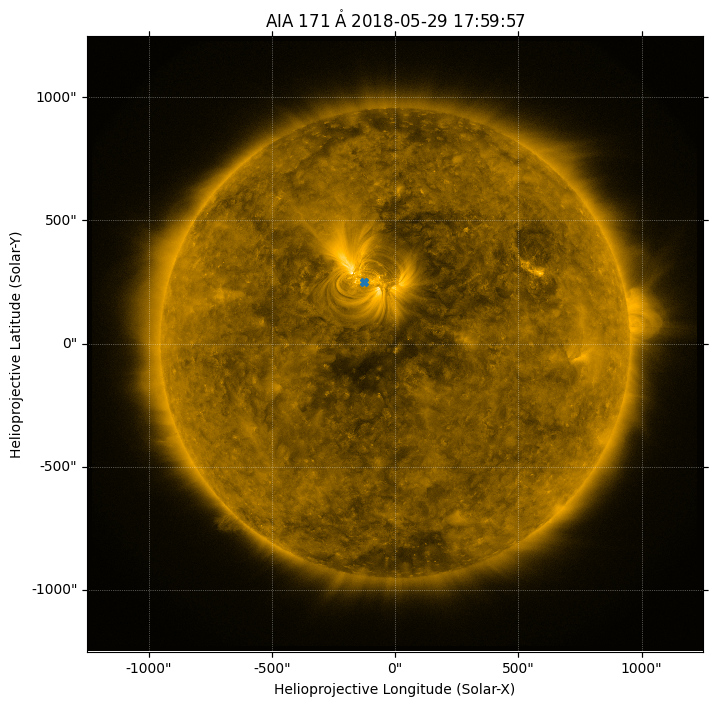

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=ref_map_full_disk)
ref_map_full_disk.plot(axes=ax)
ax.plot_coord(ar_center, marker='X', color='C0')

Next, we want to create a cutout around the active region.
This will help us define our bounding box for the rest of our cutouts.

In [9]:
fov_expanded = (500,600)*u.arcsec

In [10]:
cutout = Cutout2D(ref_map_full_disk.data, ar_center, fov_expanded, wcs=ref_map_full_disk.wcs)
ref_map_cutout = sunpy.map.Map(cutout.data, cutout.wcs, plot_settings=ref_map_full_disk.plot_settings)

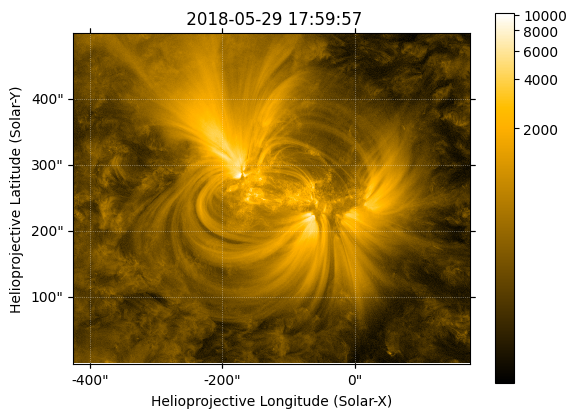

In [11]:
ref_map_cutout.peek()

Lastly, we'll reproject the cutout and crop it a bit closer to the active region

In [12]:
fov = [500,500]*u.arcsec

In [13]:
ref_map_cutout_reprojected = reproject_cutout(
    cutout_from_s3_file(file_list['datakey'][-1], ar_center, fov_expanded),
    ref_map_cutout.wcs,
    ar_center,
    fov
)

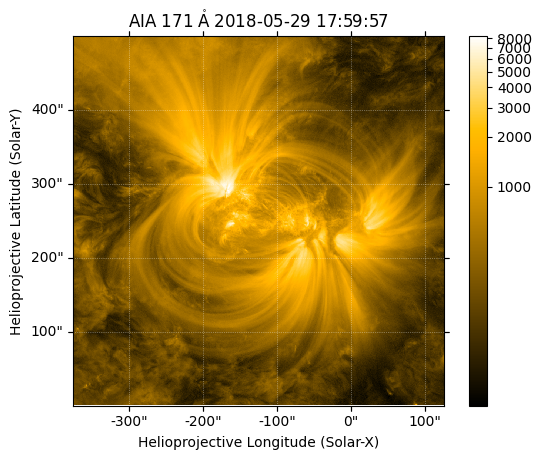

In [14]:
ref_map_cutout_reprojected.peek()

## Create Dask Cluster

In [15]:
gateway = Gateway()

In [16]:
options = gateway.cluster_options()
options.worker_cores = 4
options.worker_memory = 8

In [17]:
cluster = gateway.new_cluster(options)

In [18]:
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/daskhub.7168682eb82d4b6b9807479a2610bbb0/status,


In [19]:
pip_plugin = PipInstall(
    packages=[
        "ndcube",
        "sunpy[map]",
        "astropy",
    ],
    pip_options=["--upgrade"],
)
client.register_worker_plugin(pip_plugin)

{}

In [20]:
cluster.scale(5)

## Cropping All Maps

Now that we've identified our region of interest, we can crop all of our maps at each timestep to this same field of view.

In [21]:
cutouts_171 = client.map(cutout_from_s3_file, file_list['datakey'], center=ar_center, fov=fov_expanded)

In [22]:
time_171 = astropy.time.Time(client.gather(client.map(lambda x: x.date, cutouts_171)))
time_171 = (time_171 - time_start).to('s')

## Exposure Time Normalization

In [23]:
cutouts_171_normalized = client.map(lambda x: x/x.exposure_time, cutouts_171)

## Reprojecting Cutouts

In [24]:
cutouts_reprojected_171 = client.map(reproject_cutout, cutouts_171_normalized, wcs_ref=ref_map_cutout.wcs, center=ar_center, fov=fov)

## Stacking Images

- stack arrays
- interpolate
- build WCS with common (and uniform) time axis
- return resulting NDCube

In [25]:
cadence = 4*u.min
time_common = np.arange(0, (time_end - time_start).to_value('s'), cadence.to_value('s')) * u.s

Because each filter of the AIA telescope does not take an observation at exactly the same time, we need to interpolate each data cube corresponding each channel to a common time array.

In [30]:
cube_171 = stack_and_interpolate(cutouts_reprojected_171, time_171, time_common)

## Now do this for another channel...

In [33]:
file_list = search_registry(time_start, time_end, 193*u.angstrom)

In [64]:
cutouts_193 = client.map(cutout_from_s3_file, file_list['datakey'], center=ar_center, fov=fov_expanded)

In [36]:
time_193 = astropy.time.Time(client.gather(client.map(lambda x: x.date, cutouts_193)))
time_193 = (time_193 - time_start).to('s')

In [37]:
cutouts_193_normalized = client.map(lambda x: x/x.exposure_time, cutouts_193)

In [38]:
cutouts_reprojected_193 = client.map(reproject_cutout,
                                     cutouts_193_normalized,
                                     wcs_ref=ref_map_cutout.wcs,
                                     center=ar_center,
                                     fov=fov)

In [39]:
cube_193 = stack_and_interpolate(cutouts_reprojected_193, time_193, time_common)

In [61]:
foo = cutouts_reprojected_171[0].result()

In [62]:
foo.meta

MetaDict([('wcsaxes', 2),
          ('crpix1', 751.5),
          ('crpix2', 0.5),
          ('cdelt1', 0.00013888888888889),
          ('cdelt2', 0.00013888888888889),
          ('cunit1', 'deg'),
          ('cunit2', 'deg'),
          ('ctype1', 'HPLN-TAN'),
          ('ctype2', 'HPLT-TAN'),
          ('crval1', 0.0),
          ('crval2', 0.0),
          ('lonpole', 180.0),
          ('latpole', 0.0),
          ('mjdref', 0.0),
          ('date-obs', '2018-05-29T17:59:57.346'),
          ('mjd-obs', 58267.749969282),
          ('rsun_ref', 696000000.0),
          ('dsun_obs', 151600364097.82),
          ('hgln_obs', 0.0056385818335307),
          ('hglt_obs', -0.97776190374015),
          ('instrume', 'AIA_3'),
          ('lvl_num', 2.0),
          ('exptime', 2.0001629999999997),
          ('wavelnth', 171),
          ('waveunit', 'angstrom'),
          ('wave_str', '171_THIN'),
          ('telescop', 'SDO/AIA'),
          ('naxis1', 1002),
          ('naxis2', 1000)])

In [65]:
quality_flags = client.gather(client.map(lambda x: x.meta['quality'], cutouts_193))

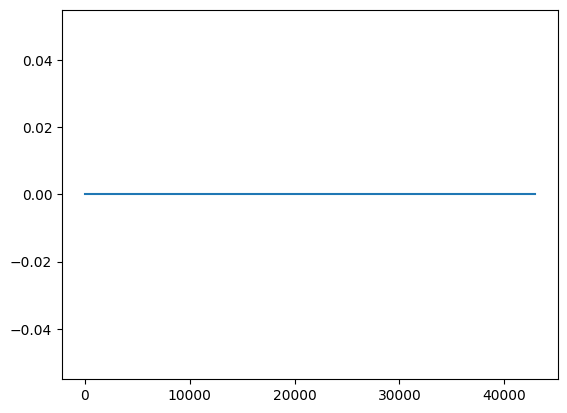

In [70]:
plt.plot(time_193, quality_flags)

## Time Lag Analysis

Some details on what a time lag is here...

In [42]:
tl_193_171 = time_lag(cube_193.data, cube_171.data, time_common, [-6,6]*u.h)

Then visualize it

## Painpoints

- Subsetting does not work on compressed files
- There is not an easy way to map a FITS image array into a Dask array and leave the image array on disk
- We have to do a bunch of individual tasks on each map before stacking all the arrays into one cube
    - These individual operations are not "dask aware", e.g. reprojection
    - Necessitates this awkward interface between lower-level functions like `map,submit` and the much more powerful `dask.array` interface
- Incompatibility between xarray and WCS approaches to coordinates systems
- Incompatibility between astropy units and Dask